# A Breached Fortress: Analyzing the Government Agency Cybersecurity Breaches

![image.png](https://www.reliasite.com/wp-content/uploads/2019/08/bigstock-Hacker-Using-Laptop-With-Binar-257453926-e1565109796243.jpg)

# The Background
---

In a not-so-distant future, a government-owned agency that plays a crucial role in national security and public welfare finds itself entangled in a series of alarming cybersecurity breaches. This agency, responsible for handling sensitive information and critical infrastructure, was once regarded as a fortress of impenetrable security measures. However, recent events have exposed its vulnerabilities and sent shockwaves through the nation.

In order to recover, this agency has tasked you with analyzing data involving its breaches. Entity names have not been disclosed for security purposes. Your mission, should you choose to accept it, is to analyze the data and uncover trends and insights regarding the breaches then add your recommendations. The future of the agency and the nation's security depends on you.

# Our Data Strategy & Analytics Workflow

In order for us to glean insights from the data in a way that would be impactful, we'll need to proceed with a framework. Our flow will be as follows:
* **Map Out Project Requirements**: We will map out how we will explore the data and find an area to improve that will allow us to add value. 
* **Get Data**: The agency has provided access to their data via CSV. We'll read the data from a file to perform our analysis.
* **Perform Data Analysis**: We'll explore the data to find trends and insights that will help us improve the agency's cybersecurity.
* **Convey Insights**: We'll present our findings and recommendations to the agency in bullet point format with action items that they can implement immediately.

Take a look at the diagram below for more details on our workflow.
   

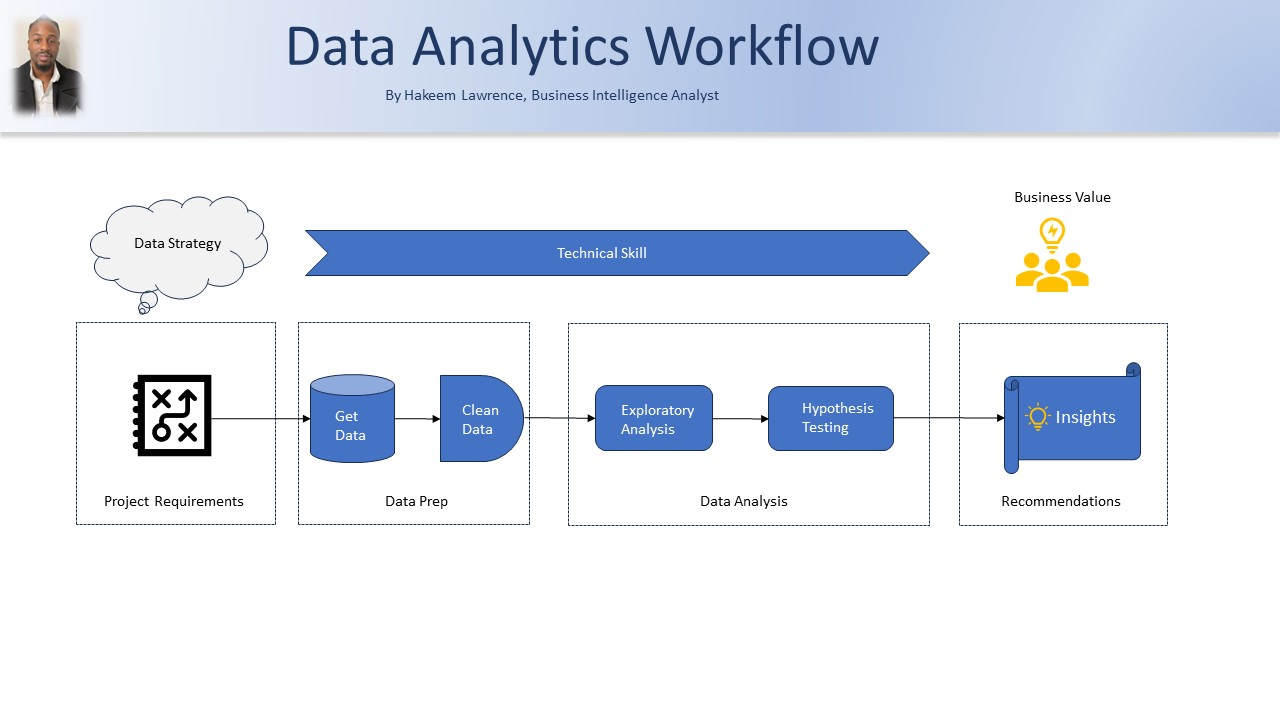

## Project Requirements

We will use the following questions to guide our analysis:
* Find the most common types of breaches. 
* Identify attributes that are likely to be associated with breaches
* View the most common types of breaches using time series analysis
* Perform hypothesis testing to determine if there is a significant difference between breach types
* Make recommendations to the agency based on our findings

# Data Profiling and Cleaning

### Data Description

| Column Name | Description |
| --- | --- |
| **ID** | Entity breached identification number |
| **Name of Covered Entity** | Cover ame for breached entities |
| **State** | State of origin for entity |
| **Business Associate Involved** | Whether or not the breach involved a business associate |
| **Individuals Affected** | Number of people affected by the breach |
| **Breach Start** | Start date of breach |
| **Breach End** | End date of breach |
| **Posted/Updated** | The date in which the breach was posted for open to public |
| **Type of Breach** | The mode of breach|
| **Location of Breached Information** |  The technical device(s) that were compromised |

Now, let's get the data from a file and take a look at it.

In [17]:
#importing libraries and data

import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_excel('CyberSecurityBreaches.xlsx')
breaches = df.copy()

In [18]:
# Inspect the data

print('First 5 rows of the data')
print(tabulate(breaches.head(), tablefmt="pipe", headers="keys"), '\n')
print('Last 5 rows of the data')
print(tabulate(breaches.tail(), tablefmt="pipe", headers="keys"), '\n')
print('Random 5 rows of the data')
print(tabulate(breaches.sample(5), tablefmt="pipe", headers="keys"))



First 5 rows of the data
|    |    ID | Name of Covered Entity   | State   | Business Associate Involved   |   Individuals Affected | Breach Start        | Breach End          | Posted/Updated      | Type of Breach   | Location of Breached Information        |
|---:|------:|:-------------------------|:--------|:------------------------------|-----------------------:|:--------------------|:--------------------|:--------------------|:-----------------|:----------------------------------------|
|  0 | 90840 | Entity 1                 | TX      | No                            |                   1711 | 2015-09-13 00:00:00 | 2015-10-15 00:00:00 | 2016-06-29 00:00:00 | Theft            | Paper                                   |
|  1 | 90711 | Entity 2                 | MO      | No                            |                    692 | 2014-07-13 00:00:00 | 2014-07-13 00:00:00 | 2016-05-29 00:00:00 | Theft            | Network Server                          |
|  2 | 90799 | Entity 3        

This looks ok to me. However, we will add a copy of Breach Start to set it as the index. That way we can perform time intelligence analytics.

In [26]:
breaches['Breach Start Index'] = breaches['Breach Start']
breaches.set_index('Breach Start Index', inplace=True)
print(tabulate(breaches.head(), tablefmt="pipe", headers="keys"), '\n')

| Breach Start Index   |    ID | Name of Covered Entity   | State   | Business Associate Involved   |   Individuals Affected | Breach Start        | Breach End          | Posted/Updated      | Type of Breach   | Location of Breached Information        |
|:---------------------|------:|:-------------------------|:--------|:------------------------------|-----------------------:|:--------------------|:--------------------|:--------------------|:-----------------|:----------------------------------------|
| 2015-09-13 00:00:00  | 90840 | Entity 1                 | TX      | No                            |                   1711 | 2015-09-13 00:00:00 | 2015-10-15 00:00:00 | 2016-06-29 00:00:00 | Theft            | Paper                                   |
| 2014-07-13 00:00:00  | 90711 | Entity 2                 | MO      | No                            |                    692 | 2014-07-13 00:00:00 | 2014-07-13 00:00:00 | 2016-05-29 00:00:00 | Theft            | Network Server            

In [41]:
# Inspect the data types

print(tabulate(breaches.dtypes.reset_index()\
                            .rename(columns={0:'dtype', 'index':'column'}), tablefmt="pipe", headers="keys"),'\n')

# Inspect the data shape

print(f'There are {breaches.shape[0]} rows and {breaches.shape[1]} columns in the data')

|    | column                           | dtype          |
|---:|:---------------------------------|:---------------|
|  0 | ID                               | int64          |
|  1 | Name of Covered Entity           | object         |
|  2 | State                            | object         |
|  3 | Business Associate Involved      | object         |
|  4 | Individuals Affected             | int64          |
|  5 | Breach Start                     | datetime64[ns] |
|  6 | Breach End                       | datetime64[ns] |
|  7 | Posted/Updated                   | datetime64[ns] |
|  8 | Type of Breach                   | object         |
|  9 | Location of Breached Information | object         | 

There are 2110 rows and 10 columns in the data


Let's now checkout the cardinality of our fields. We will surpress the output for columns with high cardinality and view those with reasonable cardinality.

In [35]:
# Create a function to describe the uniqueness of each column

def cardinality(df):
    ''' This function finds the unique values
    in each column of a dataframe. It also 
    displays the unique values in each column.'''

    for col in df.columns:
        print(f'{col} has {df[col].nunique()} unique values')
        print('High Cardinality') if df[col].nunique() > 50:
            
        else:
            print(f'The unique values are: {df[col].unique()}')
        print('\n')

# Apply the function to the data

cardinality(breaches)

ID has 2110 unique values
High Cardinality


Name of Covered Entity has 2020 unique values
High Cardinality


State has 52 unique values
High Cardinality


Business Associate Involved has 2 unique values
The unique values are: ['No' 'Yes']


Individuals Affected has 809 unique values
High Cardinality


Breach Start has 1175 unique values
High Cardinality


Breach End has 1283 unique values
High Cardinality


Posted/Updated has 855 unique values
High Cardinality


Type of Breach has 29 unique values
The unique values are: ['Theft' 'Loss' 'Other' 'Hacking/IT Incident'
 'Unauthorized Access/Disclosure ' 'Theft, Loss' 'Improper Disposal'
 'Loss, Improper Disposal' 'Theft, Other' 'Loss, Other'
 'Unauthorized Access/Disclosure'
 'Unauthorized Access/Disclosure, Hacking/IT Incident'
 'Theft, Loss, Improper Disposal'
 'Theft, Unauthorized Access/Disclosure, Hacking/IT Incident' 'Unknown'
 'Theft, Unauthorized Access/Disclosure'
 'Unauthorized Access/Disclosure, Other' 'Hacking/IT Incident, Oth

We have interesting events happening in our "Type of Breach" column and our "Location of Breached Information" column. Let's check them out in more detail.

In [86]:
# viewing type of breach proportions

type_of_breach = breaches['Type of Breach'].value_counts(normalize=True)\
                                        .mul(100)\
                                        .round(2)\
                                        .reset_index()\
                                        .rename(columns={'index':'Type of Breach', 'Type of Breach':'Pct of Total'})
                                        
print(tabulate(type_of_breach,tablefmt='pipe', headers='keys'))

|    | Type of Breach                                             |   Pct of Total |
|---:|:-----------------------------------------------------------|---------------:|
|  0 | Theft                                                      |          48.91 |
|  1 | Unauthorized Access/Disclosure                             |          14.03 |
|  2 | Other                                                      |           8.63 |
|  3 | Loss                                                       |           8.06 |
|  4 | Hacking/IT Incident                                        |           7.11 |
|  5 | Improper Disposal                                          |           3.6  |
|  6 | Theft, Unauthorized Access/Disclosure                      |           2.46 |
|  7 | Theft, Loss                                                |           1.42 |
|  8 | Unknown                                                    |           0.95 |
|  9 | Unauthorized Access/Disclosure, Hacking/IT Incident       

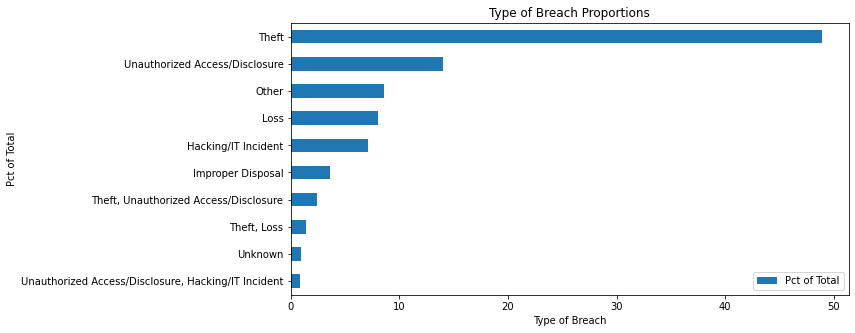

In [102]:
# plotting type of breach proportions

type_of_breach.head(10)\
            .sort_values(by= 'Pct of Total',ascending=True)\
            .plot(kind='barh', x='Type of Breach', y='Pct of Total', figsize=(10,5), legend=True)
plt.title('Type of Breach Proportions')
plt.xlabel('Type of Breach')
plt.ylabel('Pct of Total')
plt.show()

In [95]:
top_6_breaches = type_of_breach['Pct of Total'].head(6).sum().round(2)
print(f'The top 6 types of breaches account for {top_6_breaches.round(2)}% of the total breaches')

The top 6 types of breaches account for 90.34% of the total breaches


Taking a look at the column, we can see that most breach types can fall within about 8 values. We have options on how we'd like to proceed. We can bucket any event that has more than one type of breach into a big "Multi-Modes" category. We can group "Multi-Mode" events into their corresponding numeric buckets based on number of modes. Or we can create rules that adds each Multi-Mode event into a breach type based on what we believe should take precedence. Such as "If the breach contains theft, default to theft". The problem is deciding which type of breach should have the highest priority. If we consolidate to one big "Multi-Mode" category, we lose granularity. 

Considering the fact that the top 6 breach types account for 90.3% of observerations, I'm comfortable with consolidating the remaining 9.7% into a "Multi-Mode" category. The reason why I'm comfortable bucketing the remaining values into one group is because those events are so rare that they don't provide much value in terms of analysis when viewed individually.

Let's make this happen.

In [53]:
group_items_func = 'Multi-Modes' if lambda x: 

breaches['Type of Breach']

Breach Start Index
2015-09-13                             Theft
2014-07-13                             Theft
2015-04-06                             Theft
2016-04-07                              Loss
2014-09-19                             Theft
                           ...              
2014-08-07                             Theft
2011-10-17               Hacking/IT Incident
2011-12-16                       Theft, Loss
2014-10-07    Unauthorized Access/Disclosure
2013-01-06                             Theft
Name: Type of Breach, Length: 2110, dtype: object

In [30]:
# check for missing values and duplicates

print(f'There are {breaches.isna().sum().sum()} missing values in the data.')
print(f'There are {breaches.duplicated().sum()} duplicated values in the data.')

There are 2 missing values in the data.
There are 0 duplicated values in the data.


Since we know that we have missing data, let's find out where it is and deal with it.

In [31]:
missing_data = breaches.isna().sum().reset_index().rename(columns={0:'missing values', 'index':'column'})

print(tabulate(missing_data, tablefmt="pipe", headers="keys"),'\n')

|    | column                           |   missing values |
|---:|:---------------------------------|-----------------:|
|  0 | ID                               |                0 |
|  1 | Name of Covered Entity           |                0 |
|  2 | State                            |                0 |
|  3 | Business Associate Involved      |                0 |
|  4 | Individuals Affected             |                0 |
|  5 | Breach Start                     |                0 |
|  6 | Breach End                       |                2 |
|  7 | Posted/Updated                   |                0 |
|  8 | Type of Breach                   |                0 |
|  9 | Location of Breached Information |                0 | 



We have two values that are missing which belongs to a date field. In order to fill missing values, we will impute those values by first finding the average number of days between the breach start and end dates. Then we will add that average to the breach start date to fill the missing values.

In [13]:
missing_dates = breaches['Breach End'].reset_index().query('`Breach End`.isna() == True').rename(columns={'Breach Start':'missing dates'})

,missing dates,Breach End
631,2013-09-30,NaT
910,2013-09-30,NaT


In [15]:
breaches['Breach Length'] = breaches['Breach Start'] - breaches['Breach End']


KeyError: 'Breach Start'